# imports

In [29]:
# 1. 標準庫
import sys
import os
import io
import json
import glob
import random 

# 2. 第三方套件
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
import tqdm
from IPython.display import clear_output, display, HTML


# 3. 影片相關

import cv2

# 4. 設定 project 路徑（依你本機路徑調整）
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# 5. IPython 魔法指令（Jupyter專用）
%reload_ext autoreload
%autoreload 2

# 6. 共享 core_utils 函式庫導入
from core_utils.plotting import (
    plt_HWC_split_channels,
    plt_CFD_channels,
    plt_random_cfd_slice
    
)

from core_utils.utils_io import (
    np2pil,      # numpy → PIL Image
    imwrite,     # 儲存圖像為檔案
    imencode,    # 編碼圖像為 byte stream
    im2url,      # 圖像轉 base64 URL（HTML 顯示用）
    load_emoji,   # 載入 emoji 圖像
    load_cfd_npy
)

from core_utils.utils_image import (
    imshow,      # 在 notebook 顯示圖像
    tile2d,      # 多圖拼接
    zoom         # 放大圖像
)

from core_utils.utils_video import (
    save_video,  # 批次輸出影片
    VideoWriter  # 逐幀寫入影片（支援 context manager）
)

from core_utils.ops_tf_np import (
    to_rgb,
    to_rgba,
    to_alpha,
    crop_and_resize,
    get_random_cfd_slices,
    get_random_cfd_slices_pair
)


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E1_basicGNCA.utils.SamplePool import SamplePool

clear_output()

In [3]:
def get_wall_mask_via_tf(x_np, threshold=1):
    kernel_weights = [[0, 0, 1, 0, 0],
                      [0 ,0, 1, 0, 0],
                      [1, 1, 0, 1, 1],
                      [0 ,0, 1, 0, 0],
                      [0 ,0, 1, 0, 0]] 
    """
    用自訂 kernel 權重 (只加權四鄰居) 做卷積加權，回傳阈值遮罩。

    Args:
        x_np (np.ndarray): shape = (B, H, W, C)，至少 C >= 7
        kernel_weights (list or np.ndarray): 3x3 kernel，元素對應卷積權重，中心元素應該是0
        threshold (float): 閾值，卷積結果大於該值回傳 True

    Returns:
        np.ndarray: shape = (B, H, W, 1)，bool mask
    """
    x_tf = tf.convert_to_tensor(x_np, dtype=tf.float32)
    wall = x_tf[..., 6:7]  # shape: (B, H, W, 1)

    # 確保 kernel_weights 是 (3,3)
    kernel_weights = np.array(kernel_weights, dtype=np.float32)


    # reshape kernel為4D (kernel_height, kernel_width, in_channels, out_channels)
    # 這邊 in_channels=1, out_channels=1 因為只對該channel做卷積
    kernel_tf = tf.reshape(tf.constant(kernel_weights), [5, 5, 1, 1])

    # 使用padding='SAME' 保持大小
    conv_result = tf.nn.conv2d(wall, filters=kernel_tf, strides=1, padding='SAME')

    mask_tf = conv_result > threshold

    return mask_tf.numpy()

# load dataset

In [38]:
def load_case_npy(path):
    '''
    [Static Fields] (Z, Y, X, C) = (32, 82, 83, 7)
    [Dynamic Fields] (T, Z, Y, X, C) = (32, 32, 82, 83, 8)
    Static: X, Y, Z, Xnorm, Ynorm, Znorm, occupancy
    Dynamic: Ux, Uy, Uz, Umag, p, k, nut, epsilon
    '''
    file_paths = []
    for root, _, files in os.walk(path):
        files.sort()
        for name in files:
            file_paths.append(os.path.join(root, name))
            

    Static_npys = [np.load(f)  for f in file_paths if f.endswith('static_fields.npy')]
    Dynamic_npys = [np.load(f)  for f in file_paths if f.endswith('dynamic_fields.npy')]

    return  Static_npys, Dynamic_npys

Static_npys, Dynamic_npys = load_case_npy('../dataset')

(32, 118, 120, 7)


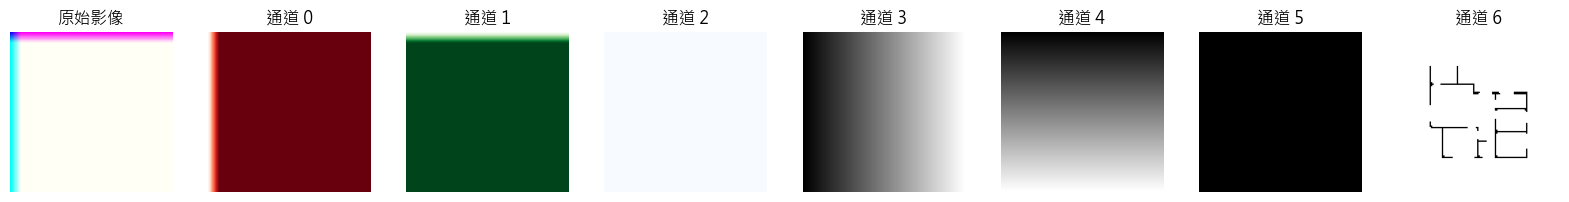

(43, 32, 118, 120, 8)


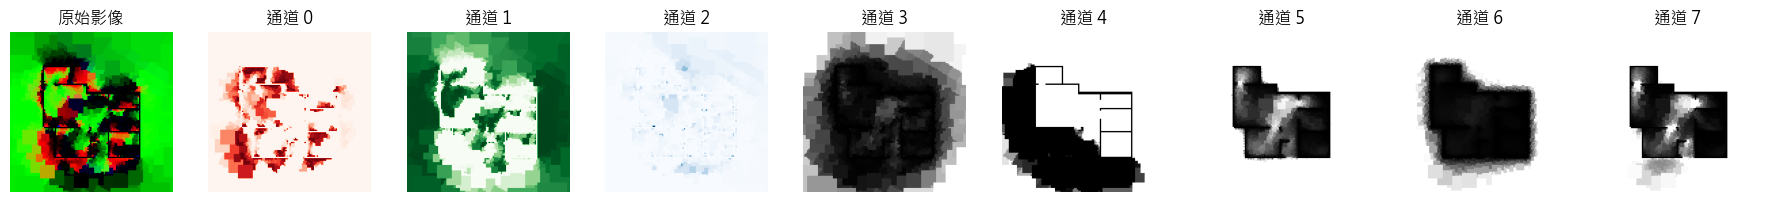

In [52]:
idx = random.randint(0, len(Static_npys) - 1)

Static = Static_npys[idx]  # 假設只取第一個 static_fields
print(Static.shape)  # 應該是 (32, 82, 83, 7)
plt_HWC_split_channels(Static[3], histogram=False, max_channels=None)

Dynamic = Dynamic_npys[idx]  # 假設只取第一個 static_fields
print(Dynamic.shape)  # 應該是 (32, 82, 83, 7)
plt_HWC_split_channels(Dynamic[-1,0,...], histogram=False, max_channels=None)

In [ ]:
# 載入檔案
dynamic_fields = load_cfd_npy('../dataset/dynamic_fields.npy')
static_fields = load_cfd_npy('../dataset/static_fields.npy')

print(dynamic_fields.shape)
print(static_fields.shape)

# plt every cfd channels in z axis
# for i in range(dynamic_fields.shape[1]):
#     plt_HWC_split_channels(dynamic_fields[0,i], histogram=False, max_channels=None)


(12, 41, 161, 161, 8)
(41, 161, 161, 7)


(1, 160, 160, 15)
(1, 160, 160, 1)


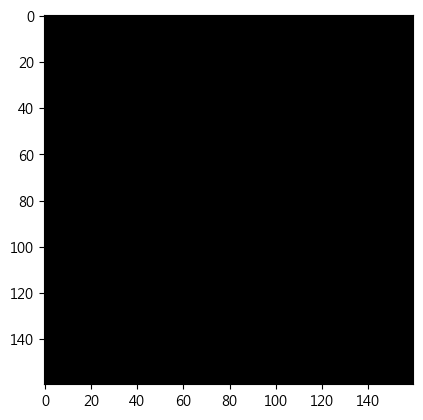

Slice 0 shape: (160, 160, 15) at Time 11 z=39 (height=3.90m)


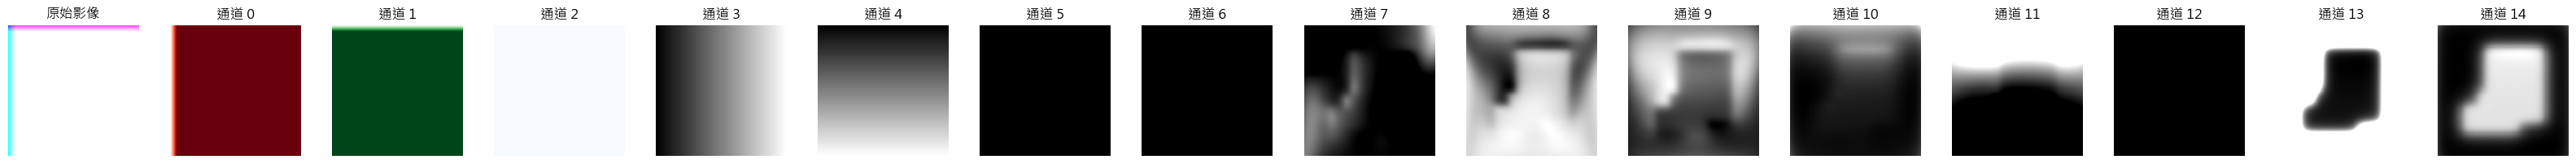

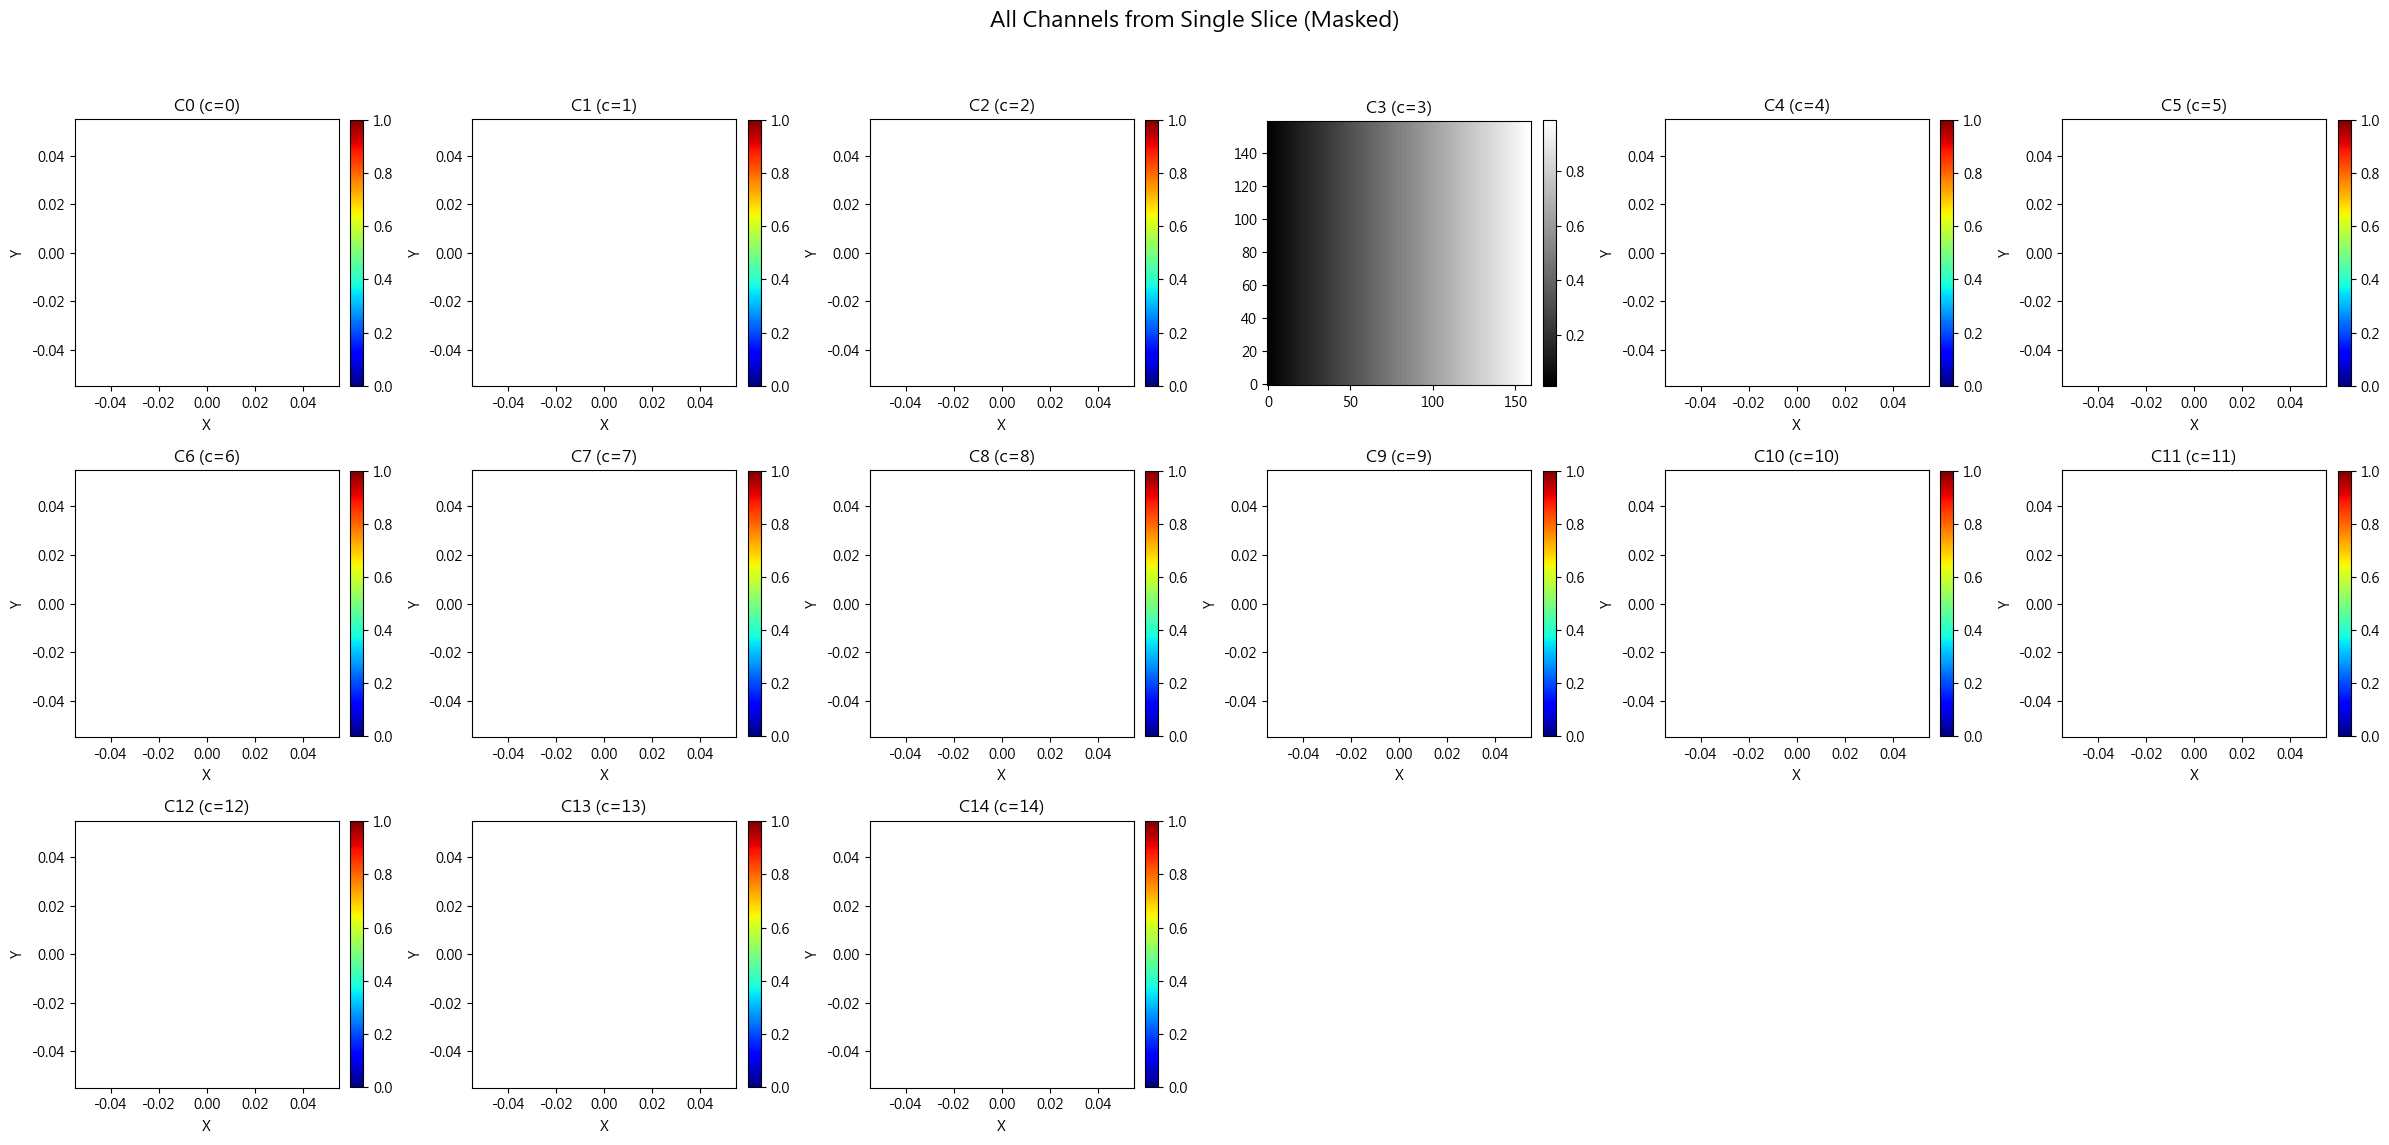

[Info] Slice shape: (160, 160, 15) (Y, X, C)
→ Channels: 15


In [17]:
slice_data, t, z = get_random_cfd_slices(dynamic_fields, static_fields, num=1)
slice_data = crop_and_resize(slice_data, target_size=(160,160), crop_size=2)
print(slice_data.shape)
print(get_wall_mask_via_tf(slice_data).shape)
windCell = slice_data[0, ..., 6]
plt.imshow(windCell, cmap='gray')
plt.show()
# for i in np.arange(0, 6, 1):
#     print(f"Threshold: {i}")
#     plt.imshow(get_wall_mask_via_tf(slice_data, threshold=i)[0, ..., 0], cmap='gray')
#     plt.show()
# slice_data *= get_wall_mask_via_tf(slice_data)
for i in range(slice_data.shape[0]):
    print(f"Slice {i} shape: {slice_data[i].shape} at Time {t[i]} z={z[i]} (height={(z[i]*0.1):.2f}m)")
    plt_HWC_split_channels(slice_data[i], histogram=False, max_channels=None)
    plt_CFD_channels(slice_data[i], channel_names=None, show_info=True, cmap='jet')